# Automated Discovery of Temperature Dependent Structural Change

    Neutron powder diffraction is a powerful way to examine the atomic structure of technologically interesting materials. The particular material from this data set is a candidate for solar cells . Nevertheless, the same methods are used in battery materials, catalysts, etc. A single data set has 2 dimensions: Intensity(I) and d spacing (d). The d spacing is a characteristic structural scale in the system. If there is a large I at a given d, that means there are at least two atoms spaced at that distance in the system. If I is at the background it means there is nothing with that d spacing in the material.
    
    Often functional behavior is related to a structural change with an external parameter like temperature. This structural change show up as change in the existence, position or width of the peaks. The provided data set is a collection of I vs d curves at multiple temperatures. So the data set is 3 dimensional I(d,T). The data is in an HDF5 file. H5py is a useful set of libraries for accessing HDF5 files from python. If you are not familiar with hdf5 and want to browse the data structure want to browse the data structure we recommend hdfview or nexpy. However, the developed algorithms should run independently of these codes.

# Challenge
    Given the aforementioned data set, here are the challenge questions
    
    1. Provide an algorithm that given the data set as an input, provides the temperature of the structural transition.
    2. Provide an algorithm that gives the integrated area under, the center of intensity, and a characteristic width for the peak that is between 3.2 and 3.3 Å in d spacing as a function of temperature.
    3. Provide an algorithm that gives the integrated area under, the center of intensity, and a characteristic width for all peaks at a given Temperature.
    4. Given adjacent temperatures, provide an algorithm that indicates if a phase transition occurred between the two temperatures, a list of centers, widths, and intensities for all peaks in the data set that are at least 1.5x above background in under 5 seconds

    Our preference is for the algorithms to be implemented in Python with use of the numpy library, other necessary libraries are welcome. If the participant prefers a compiled code, C/C++, is our preferred solution with the output being in a python or numpy data structure.

In [1]:
import numpy as np
np.set_printoptions(precision=3)
import scipy as sp
 
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rc
rc('text', usetex=True)
mpl.rcParams['savefig.dpi'] = 300
#%matplotlib notebook
%matplotlib inline
from IPython.core.pylabtools import figsize

#import h5py
from nexusformat.nexus import *
import warnings
warnings.filterwarnings('ignore')

import os
os.makedirs('Q0/Data/', exist_ok=True)
os.makedirs('Q0/Figs/', exist_ok=True)

# Q0. Sanity check.
   
   Before starting the data analysis, we do some sanity ckeck on the data. 

## 0.1 Load the data, display the tree structure, plot the data and convert the data into np arrays.

root:NXroot
  entry:NXentry
    data:NXdata
      Q = float64(5200)
        @units = '1/Angstrom'
      dspacing = float64(5200)
        @units = 'Angstrom'
      intensity = float64(140x5199)
        @axes = 'temperature,dspacing'
        @signal = 1
      temperature = float64(140)
        @units = 'Kelvin'


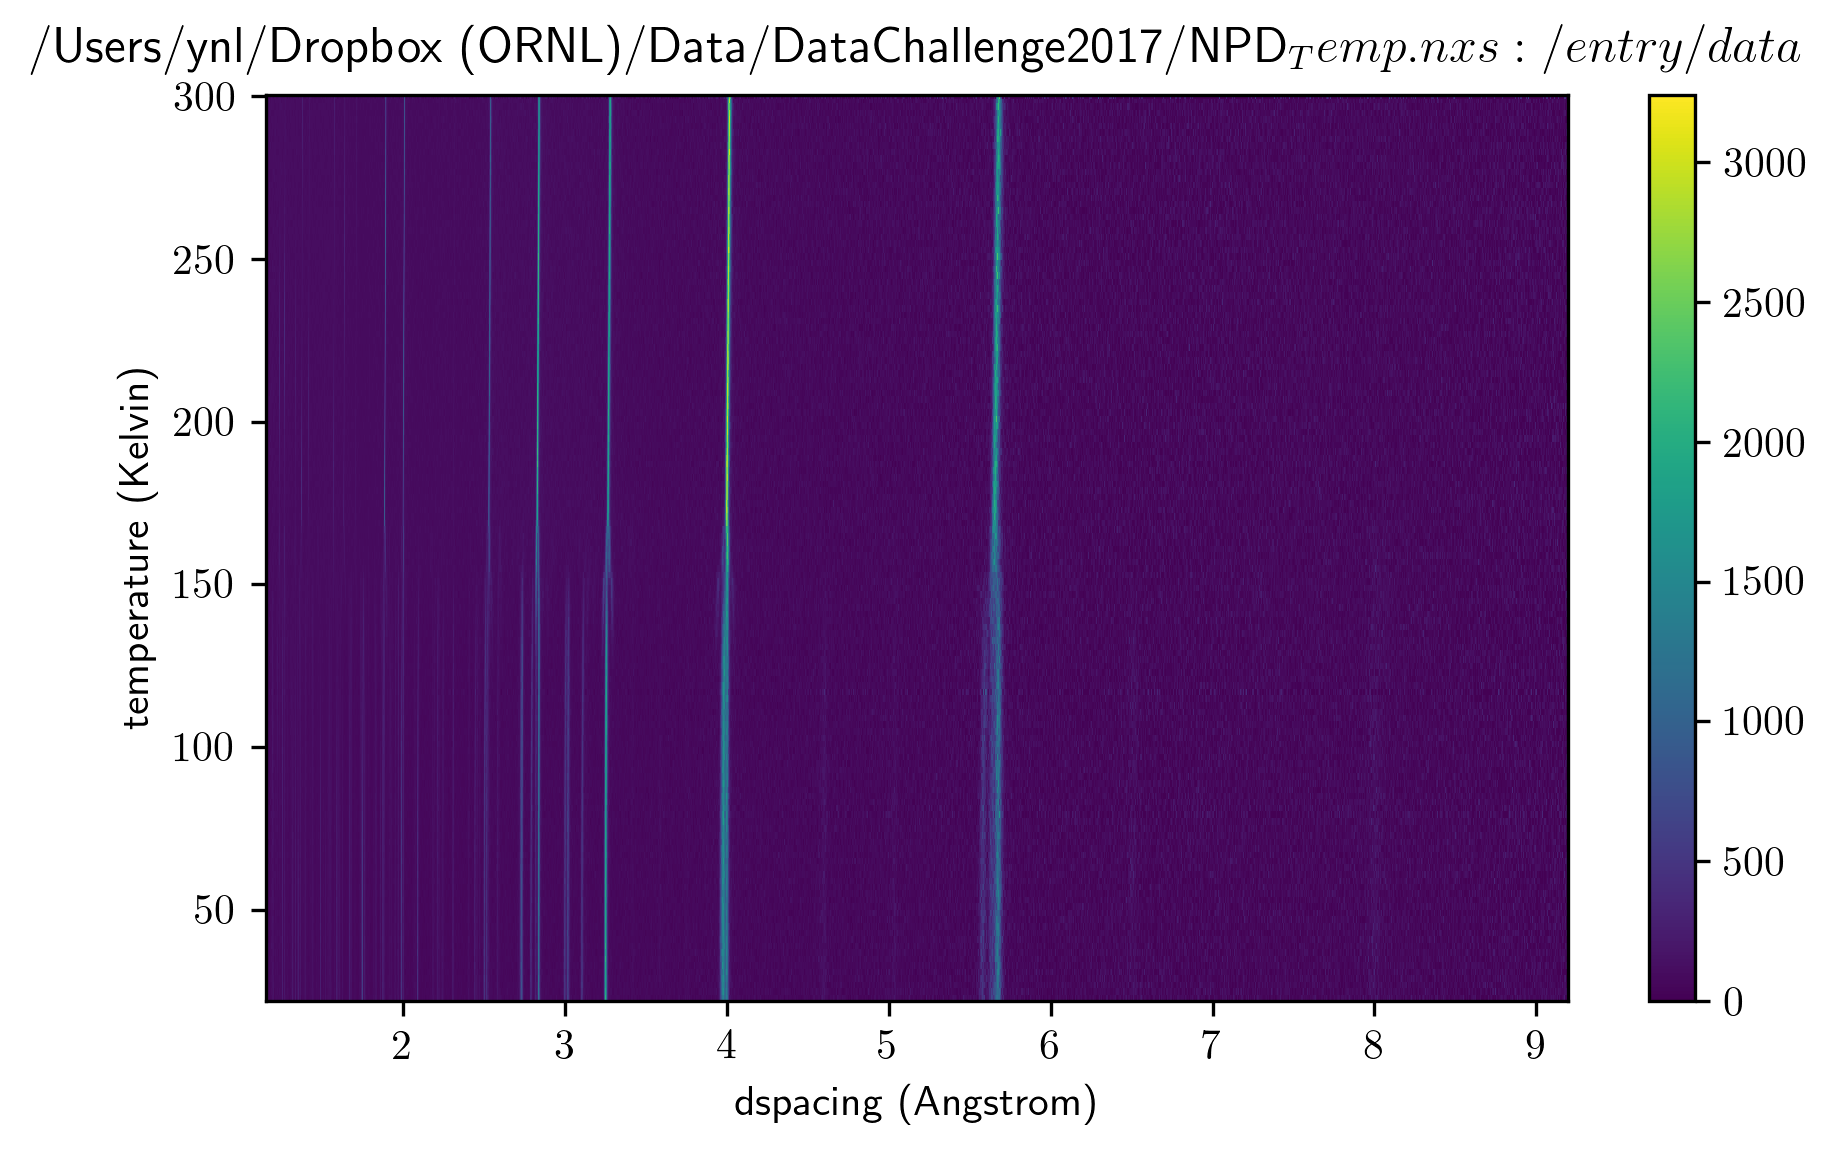

Totally 140 temperatures, and 5199 data points per temperature.


In [2]:
ff = nxload('NPD_Temp.nxs')
print(ff.tree)

#'''Need to reset to default settting of matplotlib. Otherwise nexusformat plot function will give error message.'''
figsize(7, 4)
ff.plot()

data = ff.entry.data

'''to keep the nexus format. The data format is slightly difffernt to np array.'''
#_intsy = data['intensity']
#_QQs = data['Q']
#_dds = data['dspacing']
#_temps = data['temperature']

'''convert to numpy array'''
intsy = np.asarray(data['intensity'])
QQs = np.asarray(data['Q'])
dds = np.asarray(data['dspacing'])
temps = np.asarray(data['temperature'])
dd_cs = (dds[:-1]+dds[1:])/2
temp_cs = (temps[:-1]+ temps[1:])/2

print("Totally %d temperatures, and %d data points per temperature." %(temps.size, dd_cs.size))

## 0.2 Sanity check: the total integrated counts
    
    Performing a sanity check on data quality using the total integrated counts as a function of temperature. They should have similar counts at different temperatures with a smooth change, if any. If this is not the case, it could indicates potential issues, such as data being taken with different proton charges but not correctly normalized, or sample being signifcantly moved in a non-uniform beam during the experiments.
    
    Since the unceratinty is not given, we do not calcualte the error bars. 

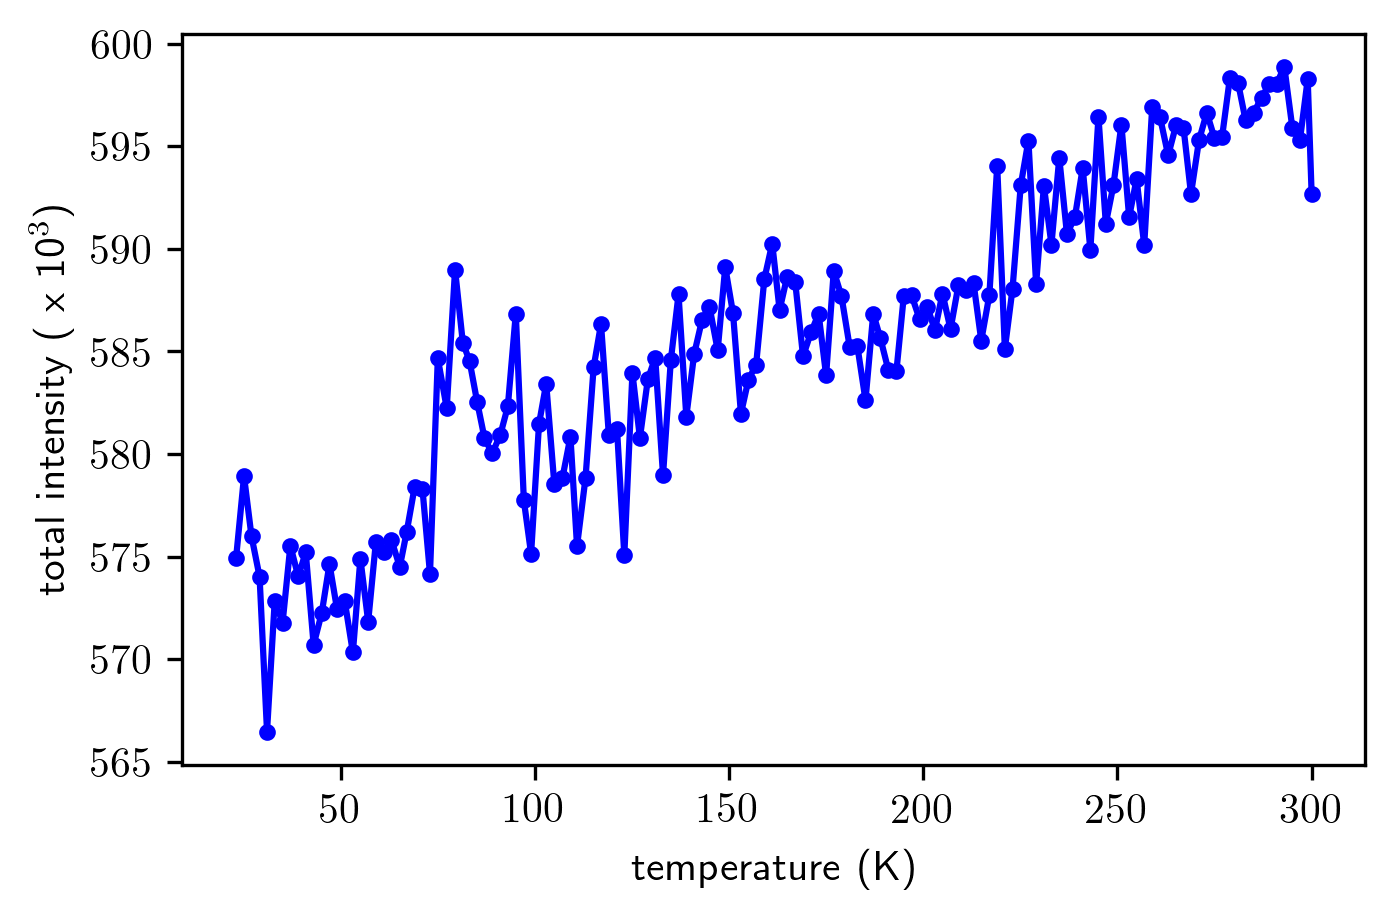

In [3]:
intsysum = intsy.T.sum(0)
_tempdata = np.vstack((temps, intsysum))
np.save('Q0/Data/total_int', _tempdata)


plt.figure(figsize(4.8, 3.2))
plt.plot(temps,  intsysum/1000, '.-', color='b')
#plt.errorbar(temps, intsysum/1000, fmt='.-', yerr = intsysum**0.5/1000, color='b')
plt.xlabel('temperature (K)')
plt.ylabel('total intensity ( x 10$^3$)')
plt.tight_layout()
plt.savefig('Q0/Figs/total_int')

## 0.3 Sanity check:  the bakcgroud level and noise level.

    We are going to use correlation functions for phase transition detection, which is known to be sensitive to the noise level. We will first use clustering algoritm to find the bakcground region and signal above background region, and then perform statistical analysis.   

    STD of background data is a good indicator of noise level.

### 0.3.1 using DBSCAN to find the background region
    a. Need a starting point for background estimation. We calculate the std of sub-dataset as a function of data below a certain percentile. We found the intensity at 50 percentile is a good starting point. 
    b. Use DBSCAN to cluster,  signal_cutoff = bkg * 1.5 * npoints
       A scale factor of s = 0.33 was selected in distance index, and eps = 1.06 was used for clustering. This selection will include 7 neighbors (include the self-point) in the d-spacing at each temperature and 3 neighbors (exclude the self-point) from each adjacent temperatures. 
       total 7 + 3*2 = 13 points. 

In [4]:
from sklearn.cluster import DBSCAN

def Find_bkg_stats(IntsyMap, db, bin_cs, x_roi=[]):
    '''
    Return the statistic information from the background, as found by DBSCAN,  
    in the x-roi.
    if x-roi is not defined. use the global information. 
    '''
    
    npars, nbins = IntsyMap.shape
    
    #if npars != len(pars):
    #    raise ValueError("Dimension mismatch on number of experimental parameters.")  
    if nbins != len(bin_cs):
        raise ValueError("Dimension mismatch on number of bins.")  
    
    if len(x_roi) > 0:
        if len(x_roi) !=2:
            raise ValueError("roi needs exactly two numbers.")  
        elif x_roi[0] > x_roi[1]:
            x_roi[0], x_roi[1] = x_roi[1], x_roi[0]

    binindx = np.arange(nbins) 
    parindx = np.arange(npars)
    xx, yy = np.meshgrid(binindx, parindx)
    pnt_loc = np.vstack((xx.flatten(), yy.flatten())).T
    
    _xx, _yy = pnt_loc[db.labels_ == -1].T
    
    bkg, bkgloc, bkgmean, bkgstd = [], [], [], []
    for ii in range(npars):
        _bkgloc = _xx[_yy==ii]
        _bkg = IntsyMap[ii, _bkgloc]
        _bkgloc = bin_cs[_bkgloc]
        
        if len(x_roi) == 2:
            roi_mask = (_bkgloc >= x_roi[0]) & (_bkgloc <= x_roi[1])
            _bkgloc = _bkgloc[roi_mask]
            _bkg = _bkg[roi_mask]
        
        bkg.append(_bkg)
        bkgloc.append(_bkgloc)
        bkgmean.append(_bkg.mean())
        bkgstd.append(_bkg.std())
    
    return bkgmean, bkgstd, bkg, bkgloc 

def Plot_Clustering(db, signal, pars, bin_cs, x_roi=[], savefilename=""):
    '''
    plot the results of DBScan:
        pnt_loc 
        signal = -1, plot background point
        signal = others, plot signal point
        
        x_roi: the region of interest for plotting the results.
    '''
    
    binindex = np.arange(len(bin_cs)) 
    parindex = np.arange(len(pars))
    xx, yy = np.meshgrid(binindex, tempindex)
    pnt_loc = np.vstack((xx.flatten(), yy.flatten())).T
    
    if signal == -1:
        _xx, _yy = pnt_loc[db.labels_ == -1].T
        title = 'Bkg points by DBSCAN.'
    else:
        _xx, _yy = pnt_loc[db.labels_ != -1].T
        title = 'Signal above background found by DBSCAN.'

    _xx = dd_cs[_xx]
    _yy = pars[_yy]
    
    plt.figure()
    plt.plot(_xx, _yy, '.', markerfacecolor='blue',
                 markeredgecolor='none', markersize=2)
    plt.xlabel('d-spacing(\AA)')
    plt.ylabel('temperature (K)')
    if len(x_roi) == 2:
        xlims = x_roi
    else:
        xlims = [_xx.min(), _xx.max()]
    ylims = [_yy.min()-5, _yy.max()+5]
    plt.xlim(xlims)
    plt.ylim(ylims)
    plt.tight_layout()
    plt.title(title)
    if len(savefilename) > 0:
        plt.savefig(savefilename, dpi=600)
    plt.show()    
    return

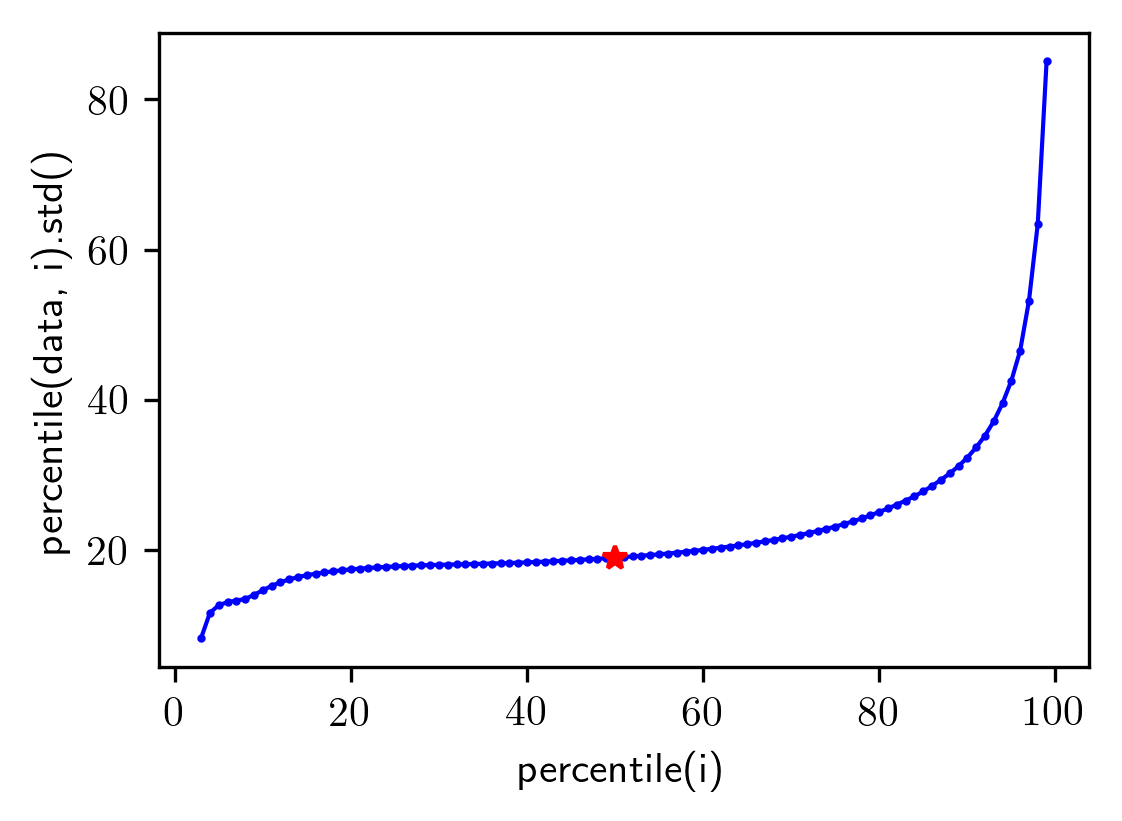

In [5]:
bkg = []
data=intsy[(temps-220).argmin()]
for i in np.arange(100):
    bkg.append(data[data<np.percentile(data, i)].std())

figsize(4., 2.8)
plt.plot(bkg, 'o-', markersize=1, linewidth = 1, color='b')
plt.ylabel('percentile(data, i).std()')
plt.xlabel('percentile(i)')
plt.plot([50], [bkg[50]], '*', color='red')
plt.savefig('Q0/Figs/std_analysis_%dK' %(220))

rough estimateion of the background level  91.8044717908
number of cutoff 1.79e+03; number ofclusters, 134, including bkg


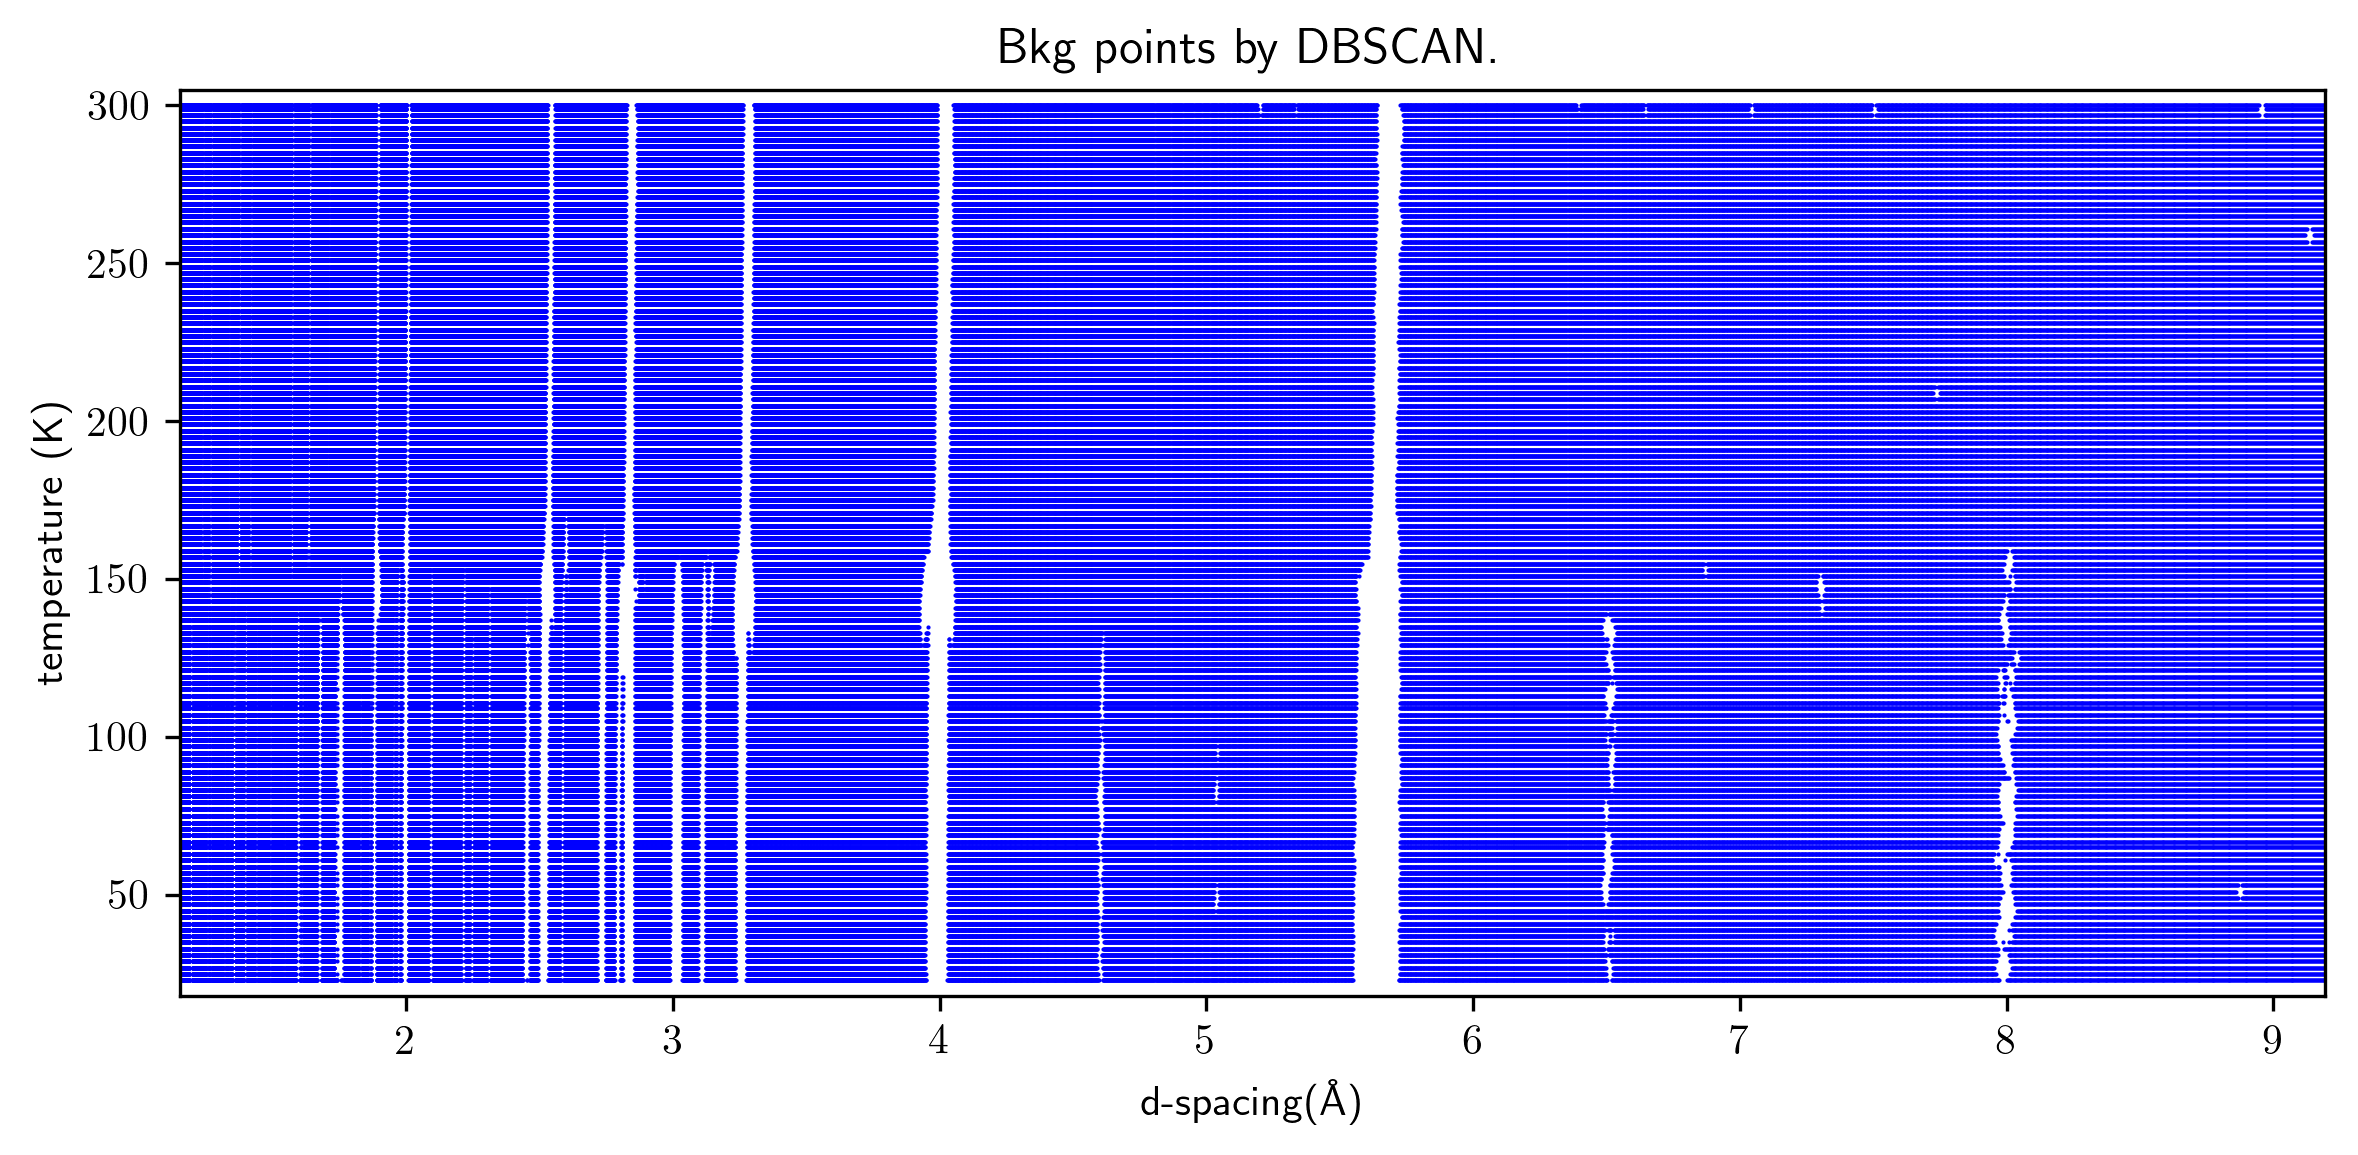

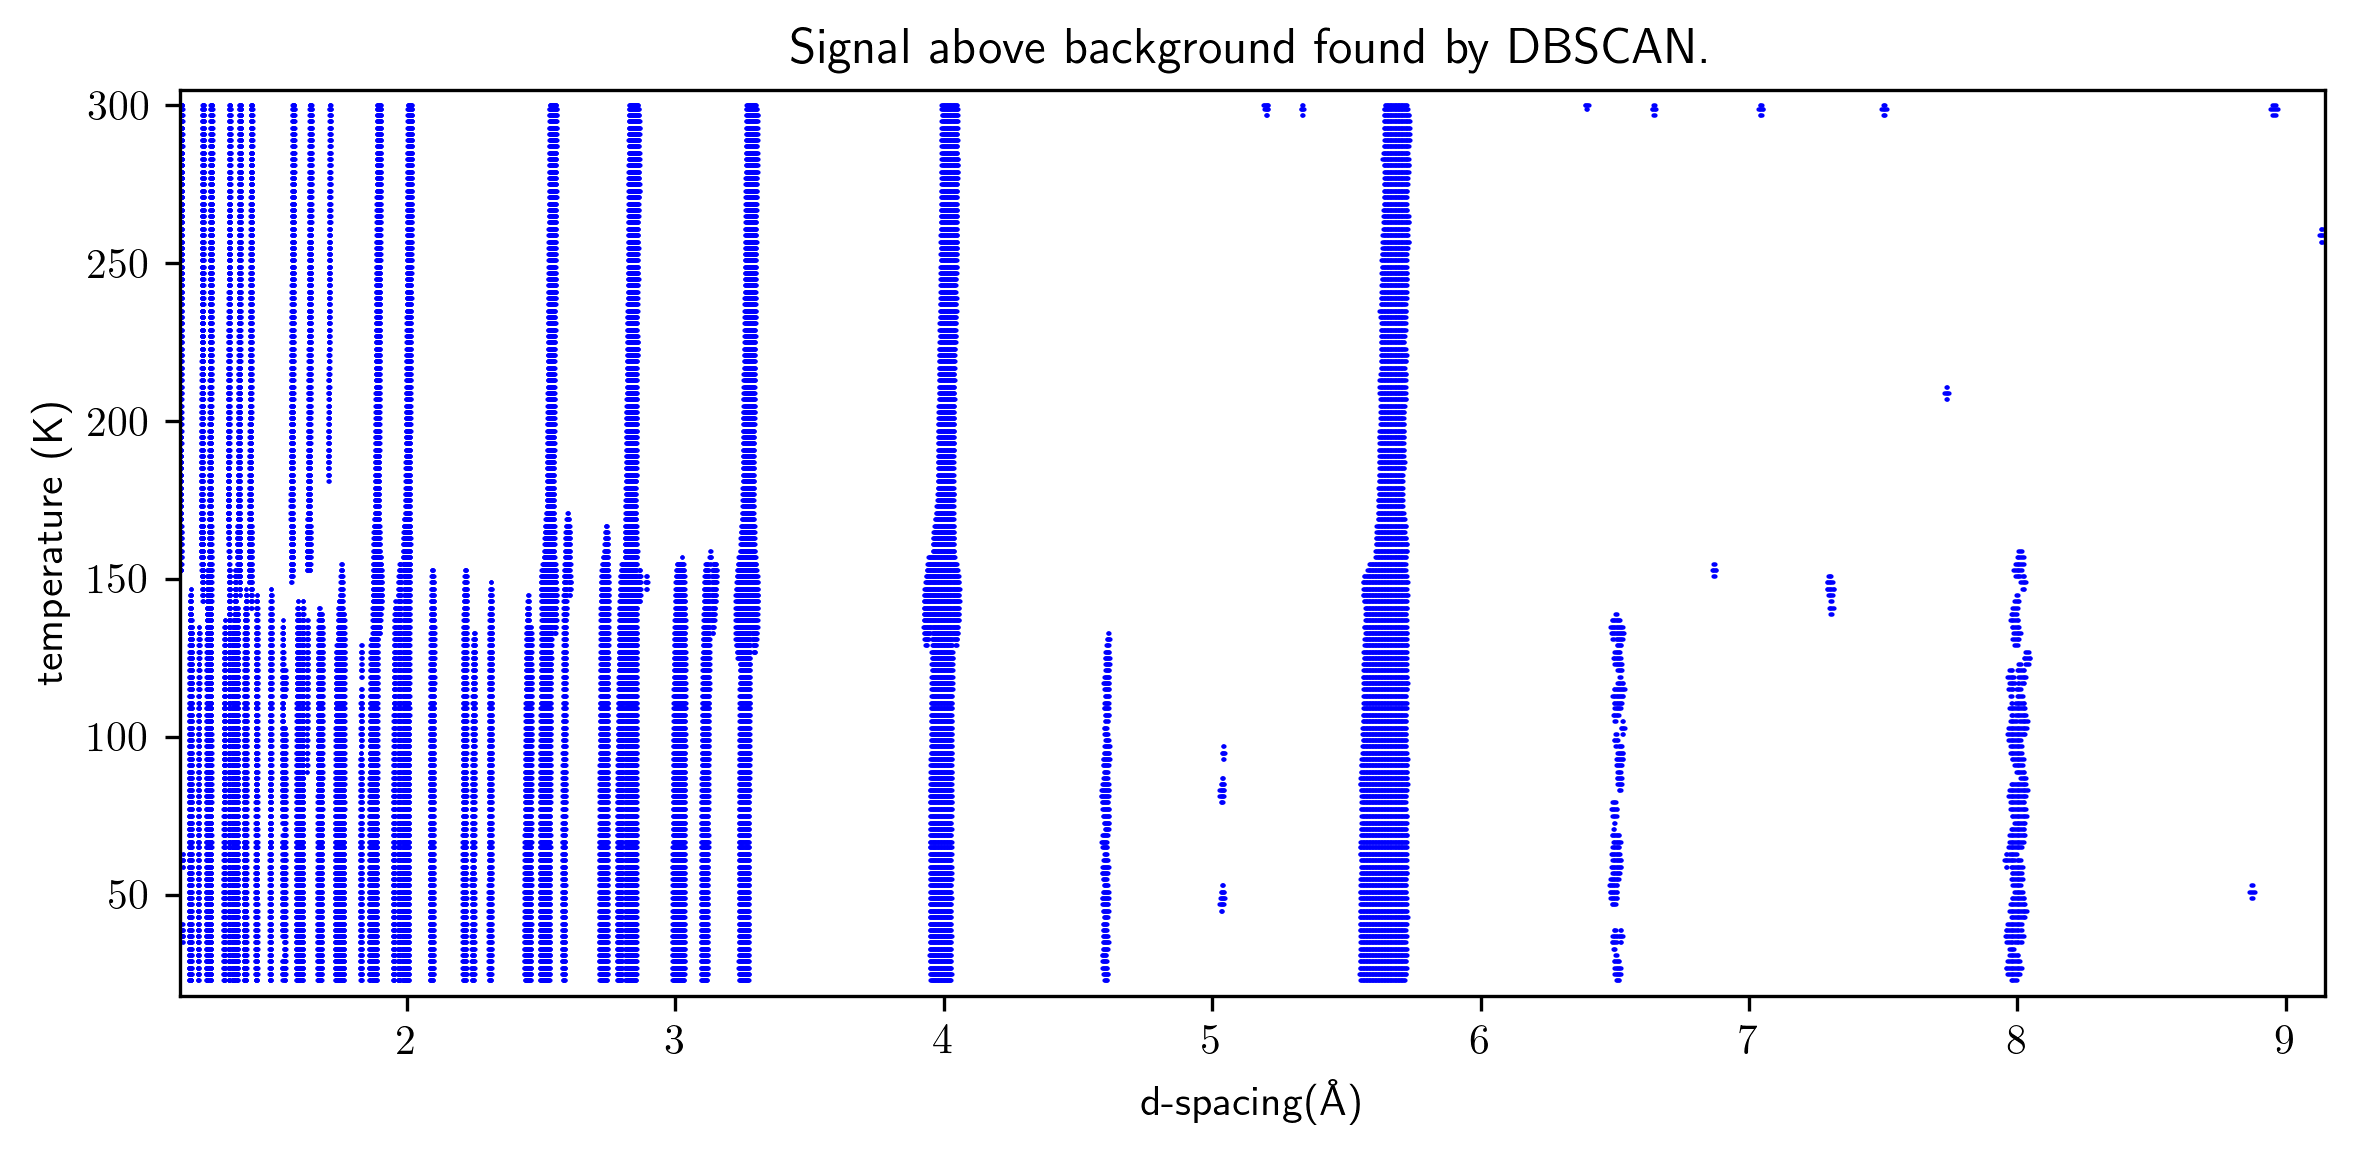

In [6]:
s = 0.33
binindex = np.arange(len(dd_cs)) * s
tempindex = np.arange(len(temps))
xx, yy = np.meshgrid(binindex, tempindex)

pnt_loc = np.vstack((xx.flatten(), yy.flatten())).T
pnt_weight = intsy.flatten()
bkg_val = np.percentile(pnt_weight, 50)
print('rough estimateion of the background level ', bkg_val)
bkg = pnt_weight[pnt_weight < bkg_val]

'''
using s=0.33, eps = 1.02 to including 7 neighbors at same temperature
and 6 at adjacent temperature.
'''
n_cutoff = np.round(13 * bkg_val  * 1.5)
db = DBSCAN(eps=1.06, min_samples=n_cutoff, n_jobs=-1).fit(pnt_loc, sample_weight = pnt_weight)
print("number of cutoff %5.2e; number ofclusters, %d, including bkg" %(n_cutoff, len(set(db.labels_))))

figsize(8, 3.8)
Plot_Clustering(db, -1, temps, dd_cs, savefilename="Q0/Figs/BKG_pnts_DBSCAN.png")
Plot_Clustering(db, 0, temps, dd_cs, savefilename="Q0/Figs/Signal_pnts_DBSCAN.png")

### 0.3.2 statistical analysis on the background data found by DBSCAN.

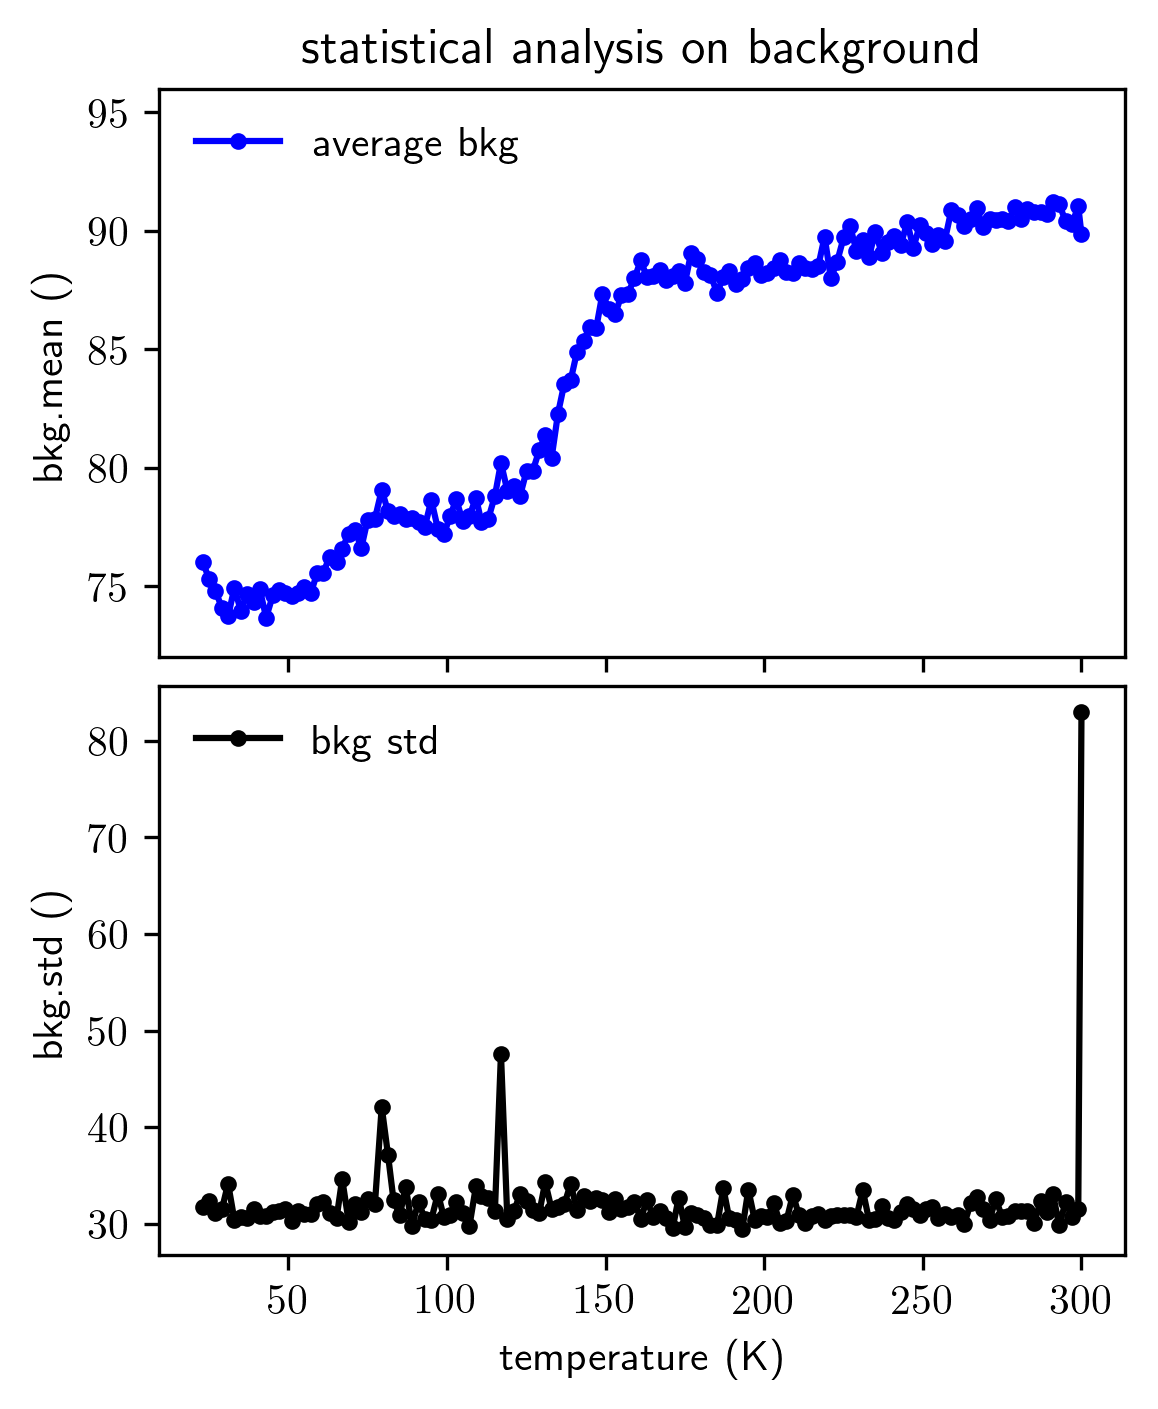

In [7]:
bkgmean, bkgstd, _, _ = Find_bkg_stats(intsy, db, dd_cs)
_bkgstat = np.vstack((temps, bkgmean, bkgstd))
np.save('Q0/Data/bkgstat', _bkgstat)

figsize(4., 4.8)
plt.figure()
ax1 = plt.subplot(211)
plt.plot(temps, bkgmean, '.-', color='blue', label='average bkg')
plt.ylabel('bkg.mean ()')
plt.ylim(72, 96)
plt.legend(loc=2, frameon=False)
ax1.set_xticklabels([])
plt.title('statistical analysis on background')
ax2 = plt.subplot(212)
plt.plot(temps, bkgstd, '.-', color='black', label='bkg std')
plt.ylabel('bkg.std ()')
plt.xlabel('temperature (K)')
plt.legend(loc=2)
plt.legend(frameon=False)
plt.tight_layout()
plt.subplots_adjust(hspace=0.05)
#plt.savefig('Q0/Figs/BkgStat_roi')


### 0.4 Examing the anomaly at the last temperature point. 
    Checked the raw data and found that the last dataset has much higher noise level. 

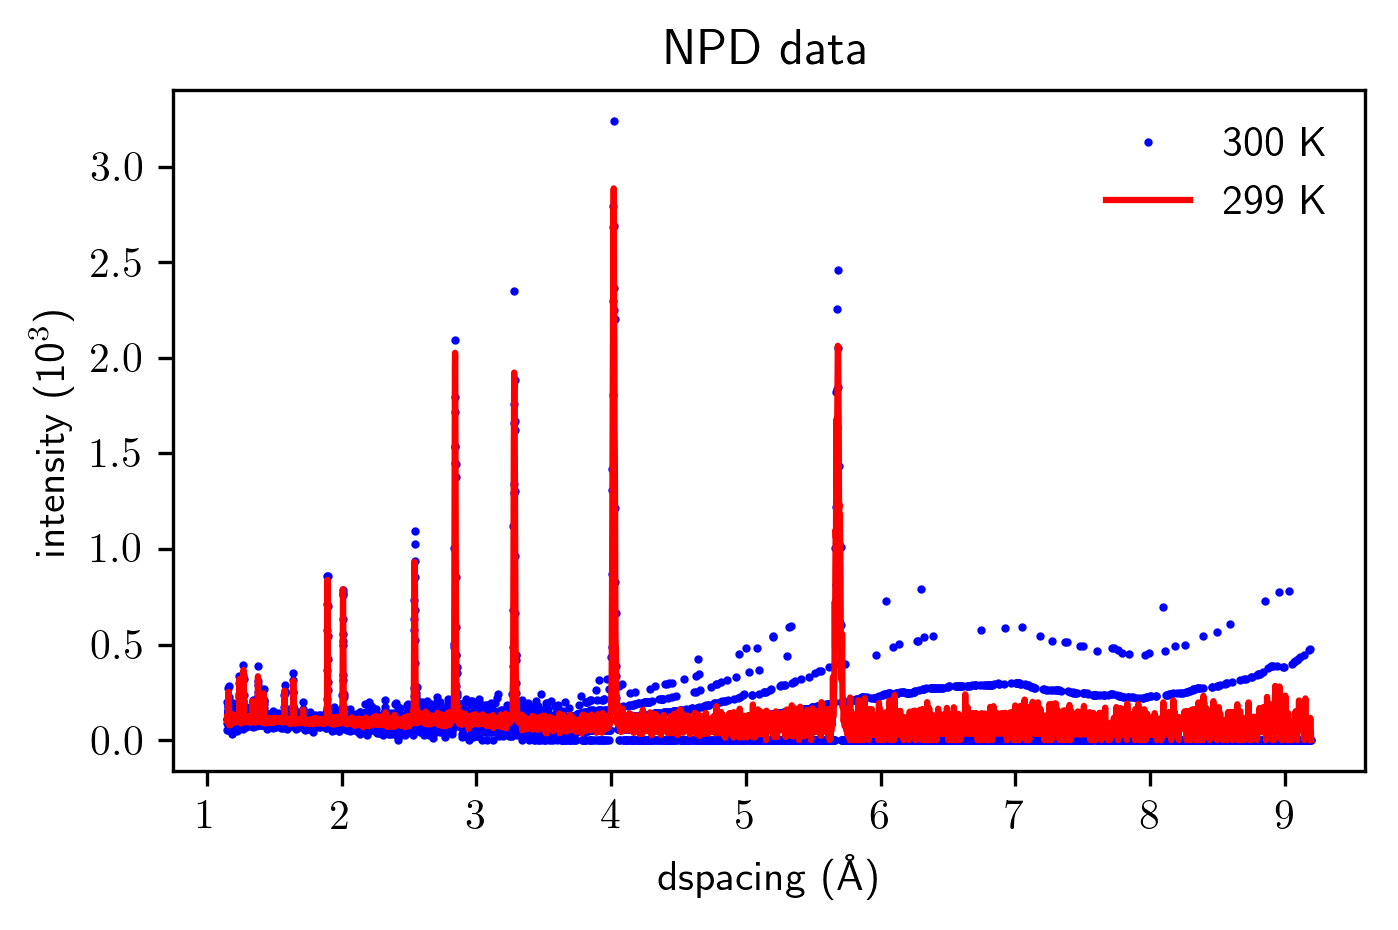

In [8]:
y0 = np.asarray(intsy[-1, :])
temp0= '%3.0f' %(temps[-1])+' K'
y1 = np.asarray(intsy[-2, :])
temp1= '%3.0f' %(temps[-2])+' K'

figsize(4.8, 3.2)
plt.figure()
plt.plot(dd_cs, y0/1000, '.', color='b', markersize =2, label=temp0)
plt.plot(dd_cs, y1/1000, '-', color='r', label=temp1)
plt.xlabel('dspacing (\AA)')
plt.ylabel('intensity (10$^3$)')
plt.legend(frameon=False)
plt.title('NPD data')
plt.tight_layout()
#plt.savefig('Q0/Figs/Last_Two_Temps_data')